In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [2]:
import tensorflow as tf

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Define blocks to build the generator
def res_block(ip):

    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)

    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)

    return add([ip,res_model])

In [5]:
def upscale_block(ip):

    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)

    return up_model

In [20]:
# Working Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    # layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [6]:
#Discrimator Version 1

from tensorflow.keras.layers import Conv2D, BatchNormalization, LeakyReLU, Flatten, Dense, Input
from tensorflow.keras.models import Model

def discriminator_block(ip, filters, strides=1, use_batch_norm=True):
    # Convolutional layer
    x = Conv2D(filters, (3, 3), strides=strides, padding="same")(ip)

    # Batch normalization (optional)
    if use_batch_norm:
        x = BatchNormalization(momentum=0.8)(x)

    # LeakyReLU activation
    x = LeakyReLU(alpha=0.2)(x)

    return x

def create_discriminator(disc_ip):
    df = 64

    # Define input layer
    input_layer = Input(shape=disc_ip.shape[1:])

    x = input_layer

    # Create the discriminator network
    for i in range(4):
        x = discriminator_block(x, df, bn=(i > 0))
        x = discriminator_block(x, df * 2, strides=2)
        df *= 2


    x = Flatten()(x)
    x = Dense(df * 16)(x)
    x = LeakyReLU(alpha=0.2)(x)

    # Output layer with sigmoid activation
    output = Dense(1, activation='sigmoid')(x)

    # Create and compile the discriminator model
    discriminator_model = Model(inputs=input_layer, outputs=output)
    discriminator_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return discriminator_model


In [7]:
#Descriminator block that will be used to construct the discriminator

def discriminator_block(ip, filters, strides=1, bn=True):

    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)

    if bn:
        disc_model = BatchNormalization( momentum=0.6 )(disc_model)

    disc_model = LeakyReLU( alpha=0.2 )(disc_model)

    return disc_model

In [8]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64

    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)

    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [9]:
#VGG19
#We need VGG19 for the feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.(as described in the paper)
#Let us pick the 3rd block, last conv layer.
#Build a pre-trained VGG19 model that outputs image features extracted at the
# third block of the model
# VGG architecture: https://github.com/keras-team/keras/blob/master/keras/applications/vgg19.py
from keras.applications import VGG19

def build_vgg(hr_shape):

    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)

    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)

In [10]:
#Combined model
import tensorflow as tf
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    print(lr_ip)
    gen_img = gen_model(lr_ip)
    output_shape = tf.image.resize(gen_img, size=(224, 224))
    print("Gen",gen_img.shape)
    gen_features = vgg(output_shape)
    print(gen_features.shape)
    disc_model.trainable = False
    validity = disc_model(output_shape)
    print("Val",validity.shape)
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.

###################################################################################

In [13]:
import os
import cv2
import numpy as np

# Set the directory paths
lr_dir = "/content/drive/MyDrive/SuperResolutionGANs/lr_images/"
hr_dir = "/content/drive/MyDrive/SuperResolutionGANs/hr_imagesOrg/"

# Get the list of file names in each directory
lr_files = os.listdir(lr_dir)
hr_files = os.listdir(hr_dir)

# Sort the file names to ensure consistent ordering
lr_files.sort()
hr_files.sort()

# Create empty lists for lr_images and hr_images
lr_images = []
hr_images = []

# Set the number of images to use (e.g., first 1000 images)
num_images = 800

# Iterate over the file names and load the corresponding images
for lr_file, hr_file in zip(lr_files[:num_images], hr_files[:num_images]):
    lr_path = os.path.join(lr_dir, lr_file)
    hr_path = os.path.join(hr_dir, hr_file)

    img_lr = cv2.imread(lr_path)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)

    img_hr = cv2.imread(hr_path)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)

# Convert the lists to numpy arrays
lr_images = np.array(lr_images)
hr_images = np.array(hr_images)


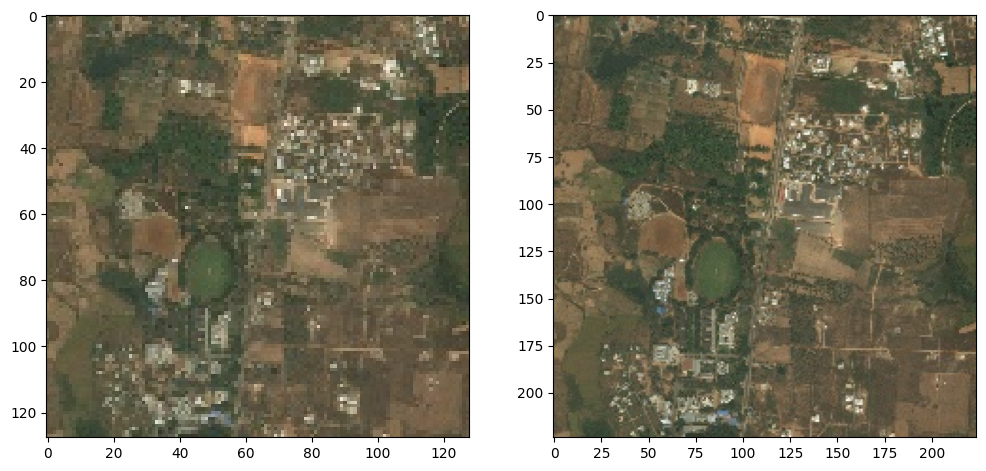

In [14]:
# Sanity check, view a random pair of images
import random
import matplotlib.pyplot as plt

image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(lr_images[image_number])
plt.subplot(122)
plt.imshow(hr_images[image_number])
plt.show()


In [15]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

In [18]:
#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images,
                                                      test_size=0.33, random_state=42)
print(hr_train.shape)
print(hr_test.shape)
print(lr_train.shape)
print(lr_test.shape)


(536, 224, 224, 3)
(264, 224, 224, 3)
(536, 128, 128, 3)
(264, 128, 128, 3)


In [21]:

from tensorflow.keras.optimizers import Adam
hr_shape = (hr_train.shape[1], hr_train.shape[2], hr_train.shape[3])
lr_shape = (lr_train.shape[1], lr_train.shape[2], lr_train.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 64)         15616     ['input_5[0][0]']             
                                                                                                  
 p_re_lu (PReLU)             (None, 128, 128, 64)         64        ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 128, 128, 64)         36928     ['p_re_lu[0][0]']             
                                                                                              

In [22]:
from tensorflow.keras import layers, models, regularizers

def create_discriminator(hr_ip):
    model = models.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=hr_ip, kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same', kernel_regularizer=regularizers.l2(0.01)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    return model


In [23]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_36 (Conv2D)          (None, 224, 224, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 224, 224, 64)      0         
                                                                 
 conv2d_37 (Conv2D)          (None, 112, 112, 64)      36928     
                                                                 
 batch_normalization_33 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 112, 112, 64)      0         
                                                           

In [24]:
vgg = build_vgg((224,224,3))
print(vgg.summary())
vgg.trainable = False
gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)


80134624/80134624 [==============================] - 3s 0us/step
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [25]:
# 2 losses... adversarial loss and content (VGG) loss
#AdversariaL: is defined based on the probabilities of the discriminator over all training samples
# use binary_crossentropy

#Content: feature map obtained by the j-th convolution (after activation)
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image.
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model (Functional)          (None, 256, 256, 3)          1453955   ['input_5[0][0]']             
                                                                                                  
 tf.image.resize (TFOpLambd  (None, 224, 224, 3)          0         ['model[0][0]']               
 a)                                                                                               
                                                                                                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                      

In [ ]:
#Creating a list of images for LR and HR in batches from which a batch of images
#would be fetched during training.
batch_size = 1
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [ ]:
# Training with Mixed Pixels
import time
g_losses_plot = []
d_losses_plot = []
epochs = 150

#Enumerate training over epochs
def mix_images(real_images, fake_images, alpha=0.1):
    return alpha * fake_images + (1 - alpha) * real_images

for e in range(epochs):
    start_time = time.time()

    fake_label = np.zeros((batch_size, 1))          # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1))            # Assign a label of 1 to all real images.

    #Create empty lists to populate gen and disc losses.
    g_losses = []
    d_losses = []

    for b in range(len(train_hr_batches)):

        lr_imgs = train_lr_batches[b]   # Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b]   # Fetch a batch of HR images for training

        fake_imgs = generator.predict_on_batch(lr_imgs) # Generate fake images
        fake_imgs_resized = tf.image.resize(fake_imgs, size=(224, 224))

        # Mix real and fake images
        mixed_imgs = mix_images(hr_imgs, fake_imgs_resized, alpha=0.1)

        # Train the discriminator on real, fake, and mixed images
        d_loss_real = discriminator.train_on_batch(hr_imgs, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_imgs_resized, np.zeros((batch_size, 1)))
        d_loss_mixed = discriminator.train_on_batch(mixed_imgs, np.zeros((batch_size, 1)))

        # Calculate average discriminator loss
        d_loss = np.mean([d_loss_real, d_loss_fake, d_loss_mixed])

            #Extract VGG features, to be used towards calculating loss
        #hr = tf.image.resize(hr_imgs, size=(224, 224))
        image_features = vgg.predict(hr_imgs)

        #Train the generator via GAN.
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])

        #Save losses to a list so we can average and report.
        d_losses.append(d_loss)
        g_losses.append(g_loss)

    #Convert the list of losses to an array to make it easy to average
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)

    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)

    #Report the progress during training.
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    # Append losses to the plot lists
    g_losses_plot.append(g_loss)
    d_losses_plot.append(d_loss)


    if (e+1) % 10 == 0:
       model_folder =  "/content/drive/MyDrive/satellite_data/Model1/"  # Make sure this folder exists or create it
       model_path = model_folder + "gen_e_" + str(e+1) + ".h5"
       generator.save(model_path)
    # if (e+1) % 2 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
    # generator.save("gen_e_"+ str(e+1) +".h5")

    # Add checkpoint callback to save model weights
   # if (e+1) % checkpoint_interval == 0:
       # generator.save_weights(checkpoint_path.format(epoch=e+1))

    end_time = time.time()  # Record the end time for the epoch
    epoch_time = end_time - start_time
    print("Time taken for epoch", e+1, ":", epoch_time, "seconds")


In [ ]:
# @title
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

generator = load_model('/content/drive/MyDrive/satellite_data/Model1/gen_e_150.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
# ... [your existing import statements and generator loading code] ...

# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)

# Apply Gaussian blur for denoising
denoised_image = gaussian_filter(gen_image[0], sigma=1)

# plot all four images
plt.figure(figsize=(16, 8))
plt.subplot(2, 2, 1)
plt.title('LR Image')
plt.imshow(src_image[0])

plt.subplot(2, 2, 2)
plt.title('Superresolution')
plt.imshow(gen_image[0])

plt.subplot(2, 2, 4)
plt.title('Orig. HR image')
plt.imshow(tar_image[0])

plt.show()




In [ ]:
# @title
from keras.models import load_model
from numpy.random import randint
import matplotlib.pyplot as plt
import cv2
import numpy as np

# Load the generator model
generator = load_model('/content/drive/MyDrive/satellite_data/Model1/gen_e_150.h5', compile=False)

# Assuming lr_test and hr_test are defined and contain the test images
[X1, X2] = [lr_test, hr_test]

# Select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# Generate image from source
gen_image = generator.predict(src_image)

def calculate_radiometric_difference(image1, image2):
    # Convert both images to float32 for consistent operation
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # Ensure the images have the same number of channels
    if image1.shape[-1] != image2.shape[-1]:
        if image1.shape[-1] == 1:  # Convert grayscale to color
            image1 = cv2.cvtColor(image1, cv2.COLOR_GRAY2BGR)
        elif image2.shape[-1] == 1:  # Convert grayscale to color
            image2 = cv2.cvtColor(image2, cv2.COLOR_GRAY2BGR)

    # Resize the images to the same dimensions if they are different
    if image1.shape[:2] != image2.shape[:2]:
        # Resize to the larger of the two sizes
        new_size = (max(image1.shape[1], image2.shape[1]), max(image1.shape[0], image2.shape[0]))
        image1 = cv2.resize(image1, new_size, interpolation=cv2.INTER_CUBIC)
        image2 = cv2.resize(image2, new_size, interpolation=cv2.INTER_CUBIC)

    # Calculate the absolute difference between the images
    difference = cv2.absdiff(image1, image2)
    return difference

    return colored_diff

    norm_diff = cv2.normalize(difference, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Apply a colormap to the normalized difference image
    colored_diff = cv2.applyColorMap(norm_diff, cv2.COLORMAP_JET)

    return colored_diff


# Calculate radiometric difference
radiometric_diff = calculate_radiometric_difference(gen_image[0], tar_image[0])

# Plot all four images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0, :, :, :])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0, :, :, :])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0, :, :, :])
plt.subplot(234)
plt.title('Radiometric Difference')
plt.imshow(radiometric_diff)

plt.show()


In [ ]:
sreeni_lr = cv2.imread("a.jpg")
sreeni_hr = cv2.imread("a1.jpg")

#Change images from BGR to RGB for plotting.
#Remember that we used cv2 to load images which loads as BGR.
sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

sreeni_lr = sreeni_lr / 255.
sreeni_hr = sreeni_hr / 255.

sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

generated_sreeni_hr = generator.predict(sreeni_lr)

# plot all three images
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('planet Image')
plt.imshow(sreeni_lr[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(generated_sreeni_hr[0,:,:,:])
plt.subplot(233)
plt.title('Sentinel image')
plt.imshow(sreeni_hr[0,:,:,:])

plt.show()